In [59]:
import pandas as pd
import os
import numpy as np
print("Current directory:", os.getcwd())
import sys
sys.path.append('.')
from MDQN import M_DQN_Agent
import torch
from collections import deque
from tqdm import tqdm
from Trading_Simulator import TradingEnvironment, pca_res_gen, fourier_signal_extractor

%reload_ext autoreload
%autoreload 2

Current directory: /Users/quintengeerts/Desktop/master thesis/stat_arb_thesis/empirical_analysis


In [7]:
import os
filename = 'price_df.csv'
if os.path.exists(filename):
    price_df = pd.read_csv(filename)
    price_df = price_df.rename(columns={'Unnamed: 0':'date'})
    price_df.set_index('date', inplace=True)
    price_df.index = pd.to_datetime(price_df.index)

returns = price_df.diff(1)

In [ ]:
action_to_portfolio = {0:-1, 1:0, 2: 1}


In [67]:
# PARAMETERS
seed = 100
#seed = np.random.randint(0,100000)

#writer = SummaryWriter("runs/"+"DQN_LL_new_1")
frames = 5000
BUFFER_SIZE = 1000000
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-2
eps_frames=5000
min_eps=0.025
LR = 1e-3
UPDATE_EVERY = 1
n_step = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using ", device)
eps_fixed = False
SAVE_MODEL = False
file_name = 'N1'

# Set seeds
#env.seed(seed)
#nv.action_space.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

# action_size     = env.action_space.n #### going to fix this
action_size       = 3
#state_size        = env.observation_space.shape
state_size        = [59]

agent = M_DQN_Agent(state_size=state_size,    
                        action_size=action_size,
                        layer_size=64,
                        BATCH_SIZE=BATCH_SIZE, 
                        BUFFER_SIZE=BUFFER_SIZE, 
                        LR=LR, 
                        TAU=TAU, 
                        GAMMA=GAMMA, 
                        UPDATE_EVERY=UPDATE_EVERY, 
                        device=device, 
                        seed=seed)

##########################
action_to_portfolio = {0:-1, 1:0, 2: 1}
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
output_history = []
frame = 0
if eps_fixed:
    eps = 0
else:
    eps = 1
eps_start = 1
i_episode = 1

env = TradingEnvironment(financial_dataset=price_df.dropna(axis=0, thresh=300),
                        residual_generator=pca_res_gen,
                        signal_generator=fourier_signal_extractor,
                        episode_length=100,
                        lookback_window=252,
                        signal_window=60,
                        transaction_costs=0.0,
                        short_cost=0.0)

state, _ = env.warm_up()
state_vec= state[env.tradeable_tickers].values.T # turns the dataframe for the requested tickers into a ndarray

score = 1

for frame in tqdm(range(1, frames+1)):
    action = agent.act_para(state_vec, eps)
    portfolio_allocations = np.vectorize(action_to_portfolio.get)(action) #actions need to be turned into allocations
    next_state, reward, done, info = env.step(portfolio_allocations.T)
    

    for idx, ticker in enumerate(env.old_tradeable_tickers):
        if done[ticker].values[0]:
            # if the ticker is removed from the tradeable tickers, done = true and new_state is the last one
            agent.step(state[ticker].values, action[0,idx], reward[ticker].values[0], state[ticker].values, True)
        else:
            # if the ticker is not removed from the tradeable tickers, done = false 
            agent.step(state[ticker].values, action[0,idx], reward[ticker].values[0], next_state[ticker].values, False)
    
    state     = next_state
    state_vec = next_state[env.tradeable_tickers].values.T

    score *= (env.p_l + 1)
    # linear annealing to the min epsilon value until eps_frames and from there slowly decease epsilon to 0 until the end of training
    if eps_fixed == False:
        if frame < eps_frames:
            eps = max(eps_start - (frame*(1/eps_frames)), min_eps)
        else:
            eps = max(min_eps - min_eps*((frame-eps_frames)/(frames-eps_frames)), 0.001)
    
    if frame % env.ep_N == 0:
        scores_window.append(score-1)       # save most recent score
        scores.append(score-1)              # save most recent score
        #writer.add_scalar("Average100", np.mean(scores_window), frame)
        output_history.append(np.mean(scores_window))
        env.evaluate_performance()
        print('\rEpisode {}\tFrame {} \tAverage Score: {:.2f}'.format(i_episode, frame, np.mean(scores_window)), end="")
        #if i_episode % 100 == 0:
            #print('\rEpisode {}\tFrame {}\tAverage Score: {:.2f}'.format(i_episode,frame, np.mean(scores_window)))
        i_episode +=1 
        score = 1 

Using  cpu


  2%|▏         | 100/5000 [01:44<1:37:21,  1.19s/it]

 Episode: 0 -- Annualized Return: 1.4% -- Annualized Volatility: 2.81% -- Annualized Sharpe: 0.5
 Episode: 0 -- Total ann. Return: 1.4% -- Total ann. Volatility: 2.81% -- Total ann. Sharpe: 0.5
Episode 1	Frame 100 	Average Score: 0.01

  4%|▍         | 200/5000 [03:45<1:42:50,  1.29s/it]

 Episode: 1 -- Annualized Return: 11.02% -- Annualized Volatility: 2.51% -- Annualized Sharpe: 4.39
 Episode: 1 -- Total ann. Return: 6.1% -- Total ann. Volatility: 2.68% -- Total ann. Sharpe: 2.28
Episode 2	Frame 200 	Average Score: 0.02

  6%|▌         | 300/5000 [05:56<1:41:05,  1.29s/it]

 Episode: 2 -- Annualized Return: -5.34% -- Annualized Volatility: 2.92% -- Annualized Sharpe: -1.83
 Episode: 2 -- Total ann. Return: 2.14% -- Total ann. Volatility: 2.78% -- Total ann. Sharpe: 0.77
Episode 3	Frame 300 	Average Score: 0.01

  8%|▊         | 400/5000 [08:12<1:49:39,  1.43s/it]

 Episode: 3 -- Annualized Return: -0.39% -- Annualized Volatility: 2.84% -- Annualized Sharpe: -0.14
 Episode: 3 -- Total ann. Return: 1.5% -- Total ann. Volatility: 2.8% -- Total ann. Sharpe: 0.54
Episode 4	Frame 400 	Average Score: 0.01

 10%|█         | 500/5000 [10:37<1:54:53,  1.53s/it]

 Episode: 4 -- Annualized Return: -3.86% -- Annualized Volatility: 2.53% -- Annualized Sharpe: -1.52
 Episode: 4 -- Total ann. Return: 0.41% -- Total ann. Volatility: 2.75% -- Total ann. Sharpe: 0.15
Episode 5	Frame 500 	Average Score: 0.00

 12%|█▏        | 600/5000 [13:12<1:58:51,  1.62s/it]

 Episode: 5 -- Annualized Return: 10.21% -- Annualized Volatility: 4.67% -- Annualized Sharpe: 2.19
 Episode: 5 -- Total ann. Return: 1.98% -- Total ann. Volatility: 3.16% -- Total ann. Sharpe: 0.63
Episode 6	Frame 600 	Average Score: 0.01

 14%|█▍        | 700/5000 [15:56<1:58:22,  1.65s/it]

 Episode: 6 -- Annualized Return: -5.73% -- Annualized Volatility: 2.74% -- Annualized Sharpe: -2.09
 Episode: 6 -- Total ann. Return: 0.84% -- Total ann. Volatility: 3.11% -- Total ann. Sharpe: 0.27
Episode 7	Frame 700 	Average Score: 0.00

 16%|█▌        | 800/5000 [18:59<2:12:15,  1.89s/it]

 Episode: 7 -- Annualized Return: 12.44% -- Annualized Volatility: 2.44% -- Annualized Sharpe: 5.1
 Episode: 7 -- Total ann. Return: 2.22% -- Total ann. Volatility: 3.04% -- Total ann. Sharpe: 0.73
Episode 8	Frame 800 	Average Score: 0.01

 18%|█▊        | 900/5000 [22:14<2:18:06,  2.02s/it]

 Episode: 8 -- Annualized Return: -0.28% -- Annualized Volatility: 4.01% -- Annualized Sharpe: -0.07
 Episode: 8 -- Total ann. Return: 1.94% -- Total ann. Volatility: 3.16% -- Total ann. Sharpe: 0.61
Episode 9	Frame 900 	Average Score: 0.01

 20%|██        | 1000/5000 [25:42<2:24:35,  2.17s/it]

 Episode: 9 -- Annualized Return: 5.54% -- Annualized Volatility: 3.49% -- Annualized Sharpe: 1.59
 Episode: 9 -- Total ann. Return: 2.3% -- Total ann. Volatility: 3.2% -- Total ann. Sharpe: 0.72
Episode 10	Frame 1000 	Average Score: 0.01

 22%|██▏       | 1100/5000 [29:19<2:19:45,  2.15s/it]

 Episode: 10 -- Annualized Return: -1.89% -- Annualized Volatility: 1.64% -- Annualized Sharpe: -1.15
 Episode: 10 -- Total ann. Return: 1.91% -- Total ann. Volatility: 3.09% -- Total ann. Sharpe: 0.62
Episode 11	Frame 1100 	Average Score: 0.01

 24%|██▍       | 1200/5000 [33:03<2:23:16,  2.26s/it]

 Episode: 11 -- Annualized Return: 3.37% -- Annualized Volatility: 2.05% -- Annualized Sharpe: 1.65
 Episode: 11 -- Total ann. Return: 2.03% -- Total ann. Volatility: 3.02% -- Total ann. Sharpe: 0.67
Episode 12	Frame 1200 	Average Score: 0.01

 26%|██▌       | 1300/5000 [36:59<2:32:46,  2.48s/it]

 Episode: 12 -- Annualized Return: 3.68% -- Annualized Volatility: 1.84% -- Annualized Sharpe: 2.0
 Episode: 12 -- Total ann. Return: 2.16% -- Total ann. Volatility: 2.94% -- Total ann. Sharpe: 0.73
Episode 13	Frame 1300 	Average Score: 0.01

 28%|██▊       | 1400/5000 [41:11<2:33:31,  2.56s/it]

 Episode: 13 -- Annualized Return: 11.21% -- Annualized Volatility: 4.31% -- Annualized Sharpe: 2.6
 Episode: 13 -- Total ann. Return: 2.78% -- Total ann. Volatility: 3.06% -- Total ann. Sharpe: 0.91
Episode 14	Frame 1400 	Average Score: 0.01

 30%|███       | 1500/5000 [45:45<2:44:21,  2.82s/it]

 Episode: 14 -- Annualized Return: 3.46% -- Annualized Volatility: 1.95% -- Annualized Sharpe: 1.78
 Episode: 14 -- Total ann. Return: 2.82% -- Total ann. Volatility: 3.0% -- Total ann. Sharpe: 0.94
Episode 15	Frame 1500 	Average Score: 0.01

 32%|███▏      | 1600/5000 [50:40<2:47:04,  2.95s/it]

 Episode: 15 -- Annualized Return: 0.5% -- Annualized Volatility: 1.66% -- Annualized Sharpe: 0.3
 Episode: 15 -- Total ann. Return: 2.68% -- Total ann. Volatility: 2.94% -- Total ann. Sharpe: 0.91
Episode 16	Frame 1600 	Average Score: 0.01

 34%|███▍      | 1700/5000 [55:49<2:51:01,  3.11s/it]

 Episode: 16 -- Annualized Return: -0.48% -- Annualized Volatility: 1.75% -- Annualized Sharpe: -0.27
 Episode: 16 -- Total ann. Return: 2.49% -- Total ann. Volatility: 2.88% -- Total ann. Sharpe: 0.86
Episode 17	Frame 1700 	Average Score: 0.01

 36%|███▌      | 1800/5000 [1:01:06<2:53:06,  3.25s/it]

 Episode: 17 -- Annualized Return: -1.96% -- Annualized Volatility: 1.75% -- Annualized Sharpe: -1.12
 Episode: 17 -- Total ann. Return: 2.24% -- Total ann. Volatility: 2.83% -- Total ann. Sharpe: 0.79
Episode 18	Frame 1800 	Average Score: 0.01

 38%|███▊      | 1900/5000 [1:06:32<2:45:46,  3.21s/it]

 Episode: 18 -- Annualized Return: -1.69% -- Annualized Volatility: 1.47% -- Annualized Sharpe: -1.15
 Episode: 18 -- Total ann. Return: 2.03% -- Total ann. Volatility: 2.78% -- Total ann. Sharpe: 0.73
Episode 19	Frame 1900 	Average Score: 0.01

 40%|████      | 2000/5000 [1:12:13<2:51:20,  3.43s/it]

 Episode: 19 -- Annualized Return: -1.74% -- Annualized Volatility: 1.23% -- Annualized Sharpe: -1.41
 Episode: 19 -- Total ann. Return: 1.83% -- Total ann. Volatility: 2.72% -- Total ann. Sharpe: 0.67
Episode 20	Frame 2000 	Average Score: 0.01

 42%|████▏     | 2100/5000 [1:18:13<2:57:58,  3.68s/it]

 Episode: 20 -- Annualized Return: 0.64% -- Annualized Volatility: 2.04% -- Annualized Sharpe: 0.32
 Episode: 20 -- Total ann. Return: 1.78% -- Total ann. Volatility: 2.69% -- Total ann. Sharpe: 0.66
Episode 21	Frame 2100 	Average Score: 0.01

 44%|████▍     | 2200/5000 [1:24:20<2:48:39,  3.61s/it]

 Episode: 21 -- Annualized Return: 0.58% -- Annualized Volatility: 3.48% -- Annualized Sharpe: 0.17
 Episode: 21 -- Total ann. Return: 1.72% -- Total ann. Volatility: 2.73% -- Total ann. Sharpe: 0.63
Episode 22	Frame 2200 	Average Score: 0.01

 46%|████▌     | 2300/5000 [1:30:46<2:56:22,  3.92s/it]

 Episode: 22 -- Annualized Return: 1.98% -- Annualized Volatility: 3.06% -- Annualized Sharpe: 0.65
 Episode: 22 -- Total ann. Return: 1.73% -- Total ann. Volatility: 2.75% -- Total ann. Sharpe: 0.63
Episode 23	Frame 2300 	Average Score: 0.01

 48%|████▊     | 2400/5000 [1:37:42<3:31:01,  4.87s/it]

 Episode: 23 -- Annualized Return: -2.27% -- Annualized Volatility: 4.44% -- Annualized Sharpe: -0.51
 Episode: 23 -- Total ann. Return: 1.56% -- Total ann. Volatility: 2.84% -- Total ann. Sharpe: 0.55
Episode 24	Frame 2400 	Average Score: 0.01

 50%|█████     | 2500/5000 [1:44:50<2:57:57,  4.27s/it]

 Episode: 24 -- Annualized Return: -8.07% -- Annualized Volatility: 4.68% -- Annualized Sharpe: -1.72
 Episode: 24 -- Total ann. Return: 1.16% -- Total ann. Volatility: 2.94% -- Total ann. Sharpe: 0.39
Episode 25	Frame 2500 	Average Score: 0.00

 52%|█████▏    | 2600/5000 [1:52:10<2:52:31,  4.31s/it]

 Episode: 25 -- Annualized Return: 2.05% -- Annualized Volatility: 4.06% -- Annualized Sharpe: 0.5
 Episode: 25 -- Total ann. Return: 1.19% -- Total ann. Volatility: 2.99% -- Total ann. Sharpe: 0.4
Episode 26	Frame 2600 	Average Score: 0.00

 54%|█████▍    | 2700/5000 [1:59:45<3:16:02,  5.11s/it]

 Episode: 26 -- Annualized Return: 3.3% -- Annualized Volatility: 2.6% -- Annualized Sharpe: 1.27
 Episode: 26 -- Total ann. Return: 1.27% -- Total ann. Volatility: 2.98% -- Total ann. Sharpe: 0.43
Episode 27	Frame 2700 	Average Score: 0.01

 56%|█████▌    | 2800/5000 [2:07:32<2:46:46,  4.55s/it]

 Episode: 27 -- Annualized Return: -1.74% -- Annualized Volatility: 1.83% -- Annualized Sharpe: -0.95
 Episode: 27 -- Total ann. Return: 1.16% -- Total ann. Volatility: 2.94% -- Total ann. Sharpe: 0.39
Episode 28	Frame 2800 	Average Score: 0.00

 58%|█████▊    | 2900/5000 [2:15:32<2:53:38,  4.96s/it]

 Episode: 28 -- Annualized Return: -2.78% -- Annualized Volatility: 1.86% -- Annualized Sharpe: -1.49
 Episode: 28 -- Total ann. Return: 1.02% -- Total ann. Volatility: 2.91% -- Total ann. Sharpe: 0.35
Episode 29	Frame 2900 	Average Score: 0.00

 60%|██████    | 3000/5000 [2:23:36<2:51:09,  5.13s/it]

 Episode: 29 -- Annualized Return: -0.05% -- Annualized Volatility: 1.9% -- Annualized Sharpe: -0.03
 Episode: 29 -- Total ann. Return: 0.99% -- Total ann. Volatility: 2.89% -- Total ann. Sharpe: 0.34
Episode 30	Frame 3000 	Average Score: 0.00

 62%|██████▏   | 3100/5000 [2:31:43<2:32:19,  4.81s/it]

 Episode: 30 -- Annualized Return: -2.68% -- Annualized Volatility: 2.41% -- Annualized Sharpe: -1.11
 Episode: 30 -- Total ann. Return: 0.87% -- Total ann. Volatility: 2.87% -- Total ann. Sharpe: 0.3
Episode 31	Frame 3100 	Average Score: 0.00

 64%|██████▍   | 3200/5000 [2:39:52<2:30:26,  5.01s/it]

 Episode: 31 -- Annualized Return: -1.76% -- Annualized Volatility: 2.02% -- Annualized Sharpe: -0.87
 Episode: 31 -- Total ann. Return: 0.78% -- Total ann. Volatility: 2.85% -- Total ann. Sharpe: 0.28
Episode 32	Frame 3200 	Average Score: 0.00

 66%|██████▌   | 3300/5000 [2:47:59<2:24:54,  5.11s/it]

 Episode: 32 -- Annualized Return: 0.04% -- Annualized Volatility: 2.22% -- Annualized Sharpe: 0.02
 Episode: 32 -- Total ann. Return: 0.76% -- Total ann. Volatility: 2.83% -- Total ann. Sharpe: 0.27
Episode 33	Frame 3300 	Average Score: 0.00

 68%|██████▊   | 3400/5000 [2:56:30<2:58:27,  6.69s/it]

 Episode: 33 -- Annualized Return: 4.3% -- Annualized Volatility: 2.21% -- Annualized Sharpe: 1.94
 Episode: 33 -- Total ann. Return: 0.86% -- Total ann. Volatility: 2.82% -- Total ann. Sharpe: 0.31
Episode 34	Frame 3400 	Average Score: 0.00

 70%|███████   | 3500/5000 [3:05:12<2:03:44,  4.95s/it]

 Episode: 34 -- Annualized Return: -1.38% -- Annualized Volatility: 1.7% -- Annualized Sharpe: -0.81
 Episode: 34 -- Total ann. Return: 0.8% -- Total ann. Volatility: 2.79% -- Total ann. Sharpe: 0.29
Episode 35	Frame 3500 	Average Score: 0.00

 72%|███████▏  | 3600/5000 [3:13:14<1:53:58,  4.88s/it]

 Episode: 35 -- Annualized Return: -3.01% -- Annualized Volatility: 2.22% -- Annualized Sharpe: -1.36
 Episode: 35 -- Total ann. Return: 0.69% -- Total ann. Volatility: 2.78% -- Total ann. Sharpe: 0.25
Episode 36	Frame 3600 	Average Score: 0.00

 74%|███████▍  | 3700/5000 [3:21:32<1:41:52,  4.70s/it]

 Episode: 36 -- Annualized Return: 4.06% -- Annualized Volatility: 1.99% -- Annualized Sharpe: 2.04
 Episode: 36 -- Total ann. Return: 0.78% -- Total ann. Volatility: 2.76% -- Total ann. Sharpe: 0.28
Episode 37	Frame 3700 	Average Score: 0.00

 76%|███████▌  | 3800/5000 [3:29:35<1:33:33,  4.68s/it]

 Episode: 37 -- Annualized Return: 4.07% -- Annualized Volatility: 1.65% -- Annualized Sharpe: 2.46
 Episode: 37 -- Total ann. Return: 0.87% -- Total ann. Volatility: 2.73% -- Total ann. Sharpe: 0.32
Episode 38	Frame 3800 	Average Score: 0.00

 78%|███████▊  | 3900/5000 [3:37:35<1:26:42,  4.73s/it]

 Episode: 38 -- Annualized Return: -0.85% -- Annualized Volatility: 1.52% -- Annualized Sharpe: -0.56
 Episode: 38 -- Total ann. Return: 0.82% -- Total ann. Volatility: 2.71% -- Total ann. Sharpe: 0.3
Episode 39	Frame 3900 	Average Score: 0.00

 80%|████████  | 4000/5000 [3:45:54<1:22:54,  4.97s/it]

 Episode: 39 -- Annualized Return: 0.01% -- Annualized Volatility: 1.5% -- Annualized Sharpe: 0.01
 Episode: 39 -- Total ann. Return: 0.8% -- Total ann. Volatility: 2.69% -- Total ann. Sharpe: 0.3
Episode 40	Frame 4000 	Average Score: 0.00

 82%|████████▏ | 4100/5000 [3:54:11<1:21:52,  5.46s/it]

 Episode: 40 -- Annualized Return: -4.02% -- Annualized Volatility: 1.68% -- Annualized Sharpe: -2.39
 Episode: 40 -- Total ann. Return: 0.68% -- Total ann. Volatility: 2.67% -- Total ann. Sharpe: 0.26
Episode 41	Frame 4100 	Average Score: 0.00

 84%|████████▍ | 4200/5000 [4:02:29<1:03:50,  4.79s/it]

 Episode: 41 -- Annualized Return: -0.33% -- Annualized Volatility: 2.2% -- Annualized Sharpe: -0.15
 Episode: 41 -- Total ann. Return: 0.66% -- Total ann. Volatility: 2.66% -- Total ann. Sharpe: 0.25
Episode 42	Frame 4200 	Average Score: 0.00

 86%|████████▌ | 4300/5000 [4:10:42<56:43,  4.86s/it]  

 Episode: 42 -- Annualized Return: 5.61% -- Annualized Volatility: 2.26% -- Annualized Sharpe: 2.48
 Episode: 42 -- Total ann. Return: 0.77% -- Total ann. Volatility: 2.65% -- Total ann. Sharpe: 0.29
Episode 43	Frame 4300 	Average Score: 0.00

 88%|████████▊ | 4400/5000 [4:18:50<50:05,  5.01s/it]

 Episode: 43 -- Annualized Return: 1.45% -- Annualized Volatility: 1.68% -- Annualized Sharpe: 0.86
 Episode: 43 -- Total ann. Return: 0.78% -- Total ann. Volatility: 2.63% -- Total ann. Sharpe: 0.3
Episode 44	Frame 4400 	Average Score: 0.00

 90%|█████████ | 4500/5000 [4:27:02<38:10,  4.58s/it]

 Episode: 44 -- Annualized Return: -1.46% -- Annualized Volatility: 1.91% -- Annualized Sharpe: -0.76
 Episode: 44 -- Total ann. Return: 0.73% -- Total ann. Volatility: 2.62% -- Total ann. Sharpe: 0.28
Episode 45	Frame 4500 	Average Score: 0.00

 92%|█████████▏| 4600/5000 [4:34:46<31:11,  4.68s/it]

 Episode: 45 -- Annualized Return: 3.0% -- Annualized Volatility: 1.79% -- Annualized Sharpe: 1.68
 Episode: 45 -- Total ann. Return: 0.78% -- Total ann. Volatility: 2.6% -- Total ann. Sharpe: 0.3
Episode 46	Frame 4600 	Average Score: 0.00

 94%|█████████▍| 4700/5000 [4:42:49<24:26,  4.89s/it]

 Episode: 46 -- Annualized Return: -2.01% -- Annualized Volatility: 2.01% -- Annualized Sharpe: -1.0
 Episode: 46 -- Total ann. Return: 0.72% -- Total ann. Volatility: 2.59% -- Total ann. Sharpe: 0.28
Episode 47	Frame 4700 	Average Score: 0.00

 96%|█████████▌| 4800/5000 [4:50:47<15:50,  4.75s/it]

 Episode: 47 -- Annualized Return: 0.89% -- Annualized Volatility: 1.85% -- Annualized Sharpe: 0.48
 Episode: 47 -- Total ann. Return: 0.73% -- Total ann. Volatility: 2.58% -- Total ann. Sharpe: 0.28
Episode 48	Frame 4800 	Average Score: 0.00

 98%|█████████▊| 4900/5000 [4:58:55<08:01,  4.82s/it]

 Episode: 48 -- Annualized Return: 1.16% -- Annualized Volatility: 2.05% -- Annualized Sharpe: 0.57
 Episode: 48 -- Total ann. Return: 0.73% -- Total ann. Volatility: 2.57% -- Total ann. Sharpe: 0.29
Episode 49	Frame 4900 	Average Score: 0.00

100%|█████████▉| 4999/5000 [5:07:07<00:03,  3.69s/it]


ZeroDivisionError: division by zero

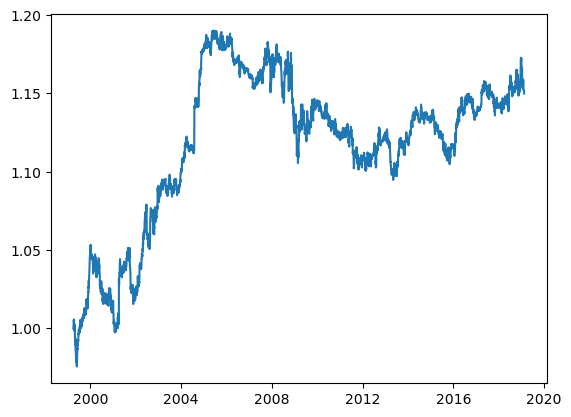

In [72]:
import matplotlib.pyplot as plt
plt.plot((env.total_pl.dropna() + 1).cumprod())